In [68]:
import pangolin as pg
from matplotlib import pyplot as plt
import numpy as np

Suppose I have two coins:

* Coin A comes up heads 75% of the time.

* Coin B comes up heads 25% of the time.

I pick one coin at random, flip it 5 times, and get the result:

T T T H T

Now I say to you, do you want to make a bet?

* If the next coinflip is H, I pay you 10 dollars.

* If the next coinflip is T, you pay me 4 dollars.

Should you take the bet?

In [69]:
# build a very simple model
coin_num = pg.bernoulli(0.5)
coins = pg.makerv([0.75, 0.25])
coin = coins[coin_num]

In [73]:
# you can print out the IR if you want
pg.print_upstream(coin)

shape | statement
----- | ---------
(2,)  | a = [0.75 0.25]
()    | b = 0.5
()    | c ~ bernoulli(b)
()    | d = index(∅)(a,c)


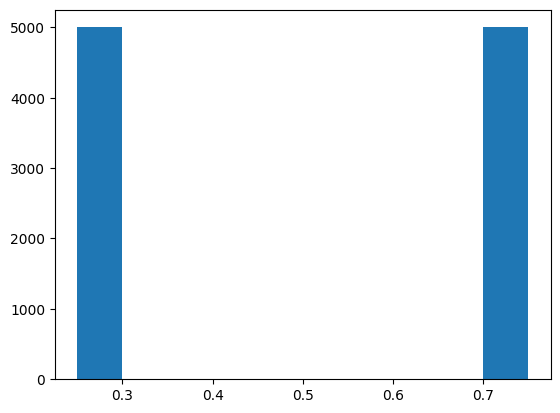

In [74]:
# do inference
coin_samples = pg.sample(coin)
plt.hist(coin_samples);

In [75]:
# add observed coinflips
num_flips = 5
coin_num = pg.bernoulli(0.5)
coin = pg.makerv([0.75,0.25])[coin_num]
flips = [pg.bernoulli(coin) for _ in range(num_flips)]

# # get samples, conditioned on observations
coin_samples = pg.sample(coin,flips,[0,0,0,1,0])
plt.hist(coin_samples);

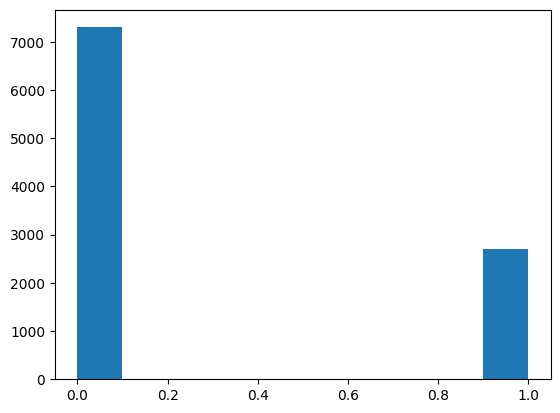

In [77]:
# get a model for the NEXT coinflip
num_flips = 5
coins = pg.makerv([0.75, 0.25])
coin_num = pg.bernoulli(0.5)
coin = coins[coin_num]
flips = [pg.bernoulli(coin) for i in range(num_flips)]
next_flip = pg.bernoulli(coin)

# get samples for next flip, conditioned on observations
next_flip_samples = pg.sample(next_flip,flips,[0,0,0,1,0])
plt.hist(next_flip_samples);

In [80]:
num_flips = 5
payments = pg.makerv([-4, 10]) # -4$ for tails, +10$ for heads
coin_num = pg.bernoulli(0.5)
coin = pg.makerv([0.75,0.25])[coin_num] # this should work!
flips = [pg.bernoulli(coin) for _ in range(num_flips)]
next_flip = pg.bernoulli(coin)
winnings = payments[next_flip]

# directly take expection, conditioned on observed flips
expected_winnings = pg.E(winnings,flips,[0,0,0,1,0])
print(f"{expected_winnings=}")

expected_winnings=Array(-0.199, dtype=float32)


Suppose I show you a coin. It looks to you like a standard US quarter, but you aren't able to
look at it very closely. I flip the coin 5 times and get the results:

H H H T H

Now, I say to you, let's make a bet:

* If the next coinflip is H, I pay you 4 dollars.

* If the next coinflip is T, you pay me 3 dollars.

Should you take the bet?

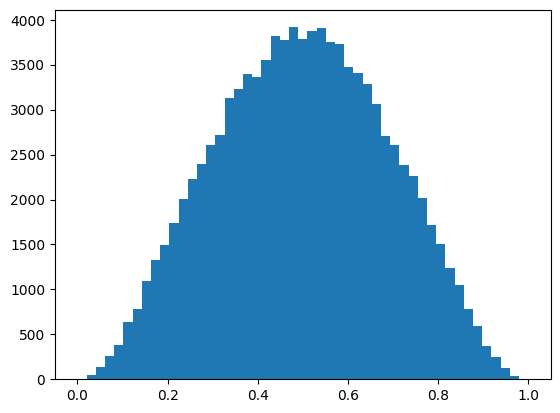

In [91]:
# this seems like a decent prior
theta = pg.beta(3,3)
thetas = pg.sample(theta,niter=100000)
plt.hist(thetas,np.linspace(0,1,50));

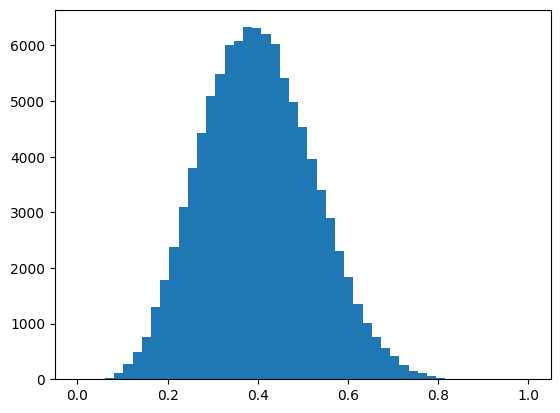

In [92]:
# model with observed samples
num_flips = 5
theta = pg.beta(5,5)
flips = [pg.bernoulli(theta) for _ in range(num_flips)]
theta_samples = pg.sample(theta,flips,[0,0,1,0,0],niter=100000)
plt.hist(theta_samples,np.linspace(0,1,50));

Should you accept the bet? If the bias of the coin is $\theta$ then you have a $\theta$ chance of
 winning a dollar and a $1-\theta$ chance of losing 4 dollars. So your expected winning is

$4 \times \theta - 3 \times (1-\theta)$.

In [93]:
expected_winning = np.mean(4*theta_samples - 3*(1-theta_samples))
print(f"{expected_winning=}")

expected_winning=Array(-0.19739957, dtype=float32)


Alternatively, you can include this calculation as part of your model.

In [97]:
# model with evidence
num_flips = 5
payments = pg.makerv([-3,4]) # lose $3 for tails, win $4 for heads
theta = pg.beta(5,5)
flips = [pg.bernoulli(theta) for _ in range(num_flips)]
new_flip = pg.bernoulli(theta)
winnings = payments[new_flip]

winnings_samples = pg.sample(winnings, flips, [0,0,1,0,0],niter=100000)
expected_winnings = np.mean(winnings_samples)
print(f"{expected_winnings=}")

expected_winnings=Array(-0.19320999, dtype=float32)


Or you can do it even more elegantly:

In [98]:
expected_winnings = pg.E(winnings, flips, [0,0,1,0,0], niter=100000)
print(f"{expected_winnings=}")

expected_winnings=Array(-0.18964, dtype=float32)


(In general it is prudent to avoid making bets with your machine learning professor.)

In [67]:
# for reference, here's how you'd do this in numpyro
from jax import numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS
from jax import random

num_flips = 5

def model():
    payments = jnp.array([-3,4])
    theta = numpyro.sample("theta",dist.Beta(5,5))
    with numpyro.plate("observations",num_flips):
        flips = numpyro.sample("flips",dist.Bernoulli(theta), obs=jnp.array([0,0,1,0,0]))
    new_flip = numpyro.sample("new_flip",dist.Bernoulli(theta))
    winnings = numpyro.deterministic("winnings",payments[new_flip])

kernel = DiscreteHMCGibbs(NUTS(model), modified=True)
mcmc = MCMC(kernel, num_warmup=10000, num_samples=10000, progress_bar=False)
mcmc.run(random.PRNGKey(0))
latent_samples = mcmc.get_samples()
predictive = numpyro.infer.Predictive(model, latent_samples)
predictive_samples = predictive(random.PRNGKey(1))
expected_winnings = jnp.mean(predictive_samples['winnings'])
print(f"{expected_winnings=}")

expected_winnings=Array(-0.21959999, dtype=float32)


Now let's consider a more elaborate situation:

* There is a jar with billions of coins in it.

* You pick out a coin and flip it 10 times, getting 8 heads. Then you put the coin back.

* You do that again, getting 7 heads.

* You keep going until you've seen 10 coins, each flipped 10 times. The total number of heads you
 see for each coin is: [8, 7, 9, 4, 10, 9, 10, 8, 8, 9]

* I draw a new coin and flip it 10 times, getting 3 heads.

* I offer you a bet:
    * Let's flip the coin 1 more time
    * If it's heads, you pay me 2 dollars
    * If it's tail, I pay you 1 dollar

Should you take the bet?

In [136]:
# https://stats.stackexchange.com/questions/12232/calculating-the-parameters-of-a-beta-distribution-using-the-mean-and-variance
mean = pg.uniform(0,1)
var = pg.uniform(0,(1-mean)*mean)
alpha = ((1-mean)/var-1/mean)*mean**2
beta = alpha * (1/mean-1)
thetas = [pg.beta(alpha,beta) for _ in range(10)]
totals = [pg.binomial(10,theta) for theta in thetas]
#new_theta = pg.beta(alpha,beta)
#new_total = pg.binomial(10,new_theta)
#final_flip = pg.bernoulli(new_theta)
#final_flip_samples = pg.sample(final_flip,[totals, new_total],[[8,7,9,4,10,9,10,8,8,9],3],
# niter=100)
#alphas, betas = pg.sample([alpha,beta],totals,[8,7,9,4,10,9,10,8,8,9],niter=100)

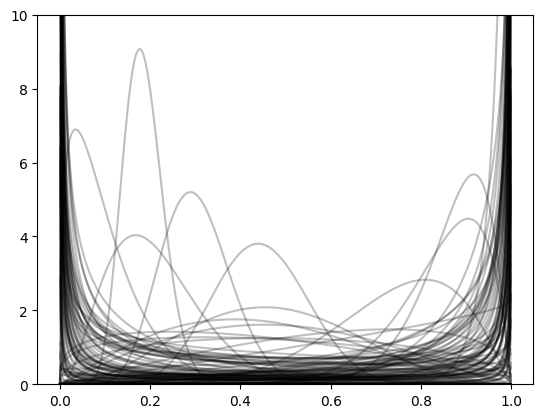

In [141]:
def plotsamps(alphas,betas):
    import scipy.stats
    x = np.arange(0,1,.001)
    for a,b in zip(alphas,betas):
        plt.plot(x,scipy.stats.beta.pdf(x,a,b),'k-',alpha=0.25)
    plt.ylim([0,10])

alphas,betas = pg.sample((alpha,beta),niter=1000)
plotsamps(alphas[::10],betas[::10])

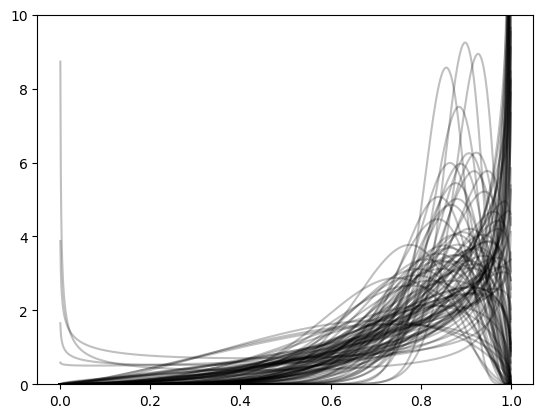

In [142]:
alphas, betas = pg.sample([alpha,beta],totals,[8,7,9,4,10,9,10,8,8,9],niter=1000)
plotsamps(alphas[::10],betas[::10])